# DIABETIC RETINOPATHY DETECTION

Diabetic retinopathy (DR), is a medical condition in which damage occurs to the retina due to diabetes mellitus. It is a leading cause of blindness. Diabetic retinopathy affects up to 80 percent of those who have had diabetes for 20 years or more. Diabetic retinopathy often has no early warning signs. **Retinal (fundus) photography with manual interpretation is a widely accepted screening tool for diabetic retinopathy**, with performance that can exceed that of in-person dilated eye examinations. 

The below figure shows an example of a healthy patient and a patient with diabetic retinopathy as viewed by fundus photography ([source](https://www.biorxiv.org/content/biorxiv/early/2018/06/19/225508.full.pdf)):

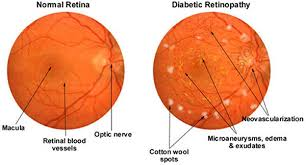

An automated tool for grading severity of diabetic retinopathy would be very useful for accerelating detection and treatment. Recently, there have been a number of attempts to utilize deep learning to diagnose DR and automatically grade diabetic retinopathy. 

This includes a previous [competition](https://kaggle.com/c/diabetic-retinopathy-detection) and [work by Google (https://ai.googleblog.com/2016/11/deep-learning-for-detection-of-diabetic.html). Even one deep-learning based system is [FDA approved](https://www.fda.gov/NewsEvents/Newsroom/PressAnnouncements/ucm604357.htm). 



## The Dataset:

>You are provided with a large set of high-resolution retina images taken under a variety of imaging conditions. A left and right field is provided for every subject. >Images are labeled with a subject id as well as either left or right (e.g. 1_left.jpeg is the left eye of patient id 1).
>
>A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4, according to the following scale:
>
>0 - No DR
>
>1 - Mild
>
>2 - Moderate
>
>3 - Severe
>
>4 - Proliferative DR

Images may contain artifacts, be out of focus, underexposed, or overexposed. A major aim of this competition is to develop robust algorithms that can function in the presence of noise and variation.




### Importing Necessary Modules

In [3]:
# data analysis
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib # visualization
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (8, 6)
from sklearn.utils import shuffle

# general purpose
import os
import random
import sys
import cv2
import gzip
import json
import PIL
import skimage
from IPython.core.display import display, HTML, Image
pd.set_option('max_columns', 50)
pd.set_option('max_rows', 1000)

from subprocess import check_output

# neural network architecture
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

C:\Users\Atheesh Krishnan\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


#### Conversion of ints to classes and classes to ints for future use

In [ ]:
#classes : 0 - No DR, 1 - Mild, 2 - Moderate, 3 - Severe, 4 - Proliferative DR
def classes_to_int(label):
    # label = classes.index(dir)
    label = label.strip()
    if label == "No DR":  return 0
    if label == "Mild":  return 1
    if label == "Moderate":  return 2
    if label == "Severe":  return 3
    if label == "Proliferative DR":  return 4
    print("Invalid Label", label)
    return 5

def int_to_classes(i):
    if i == 0: return "No DR"
    elif i == 1: return "Mild"
    elif i == 2: return "Moderate"
    elif i == 3: return "Severe"
    elif i == 4: return "Proliferative DR"
    print("Invalid class ", i)
    return "Invalid Class"

#### For image uniformity

In [ ]:
def img_to_array(img):
    """
    params: image file
    returns: reshaped image in the form of a numpy array
    """
    return np.array(img.getdata()).reshape(img.width, img.width, 3) / 255
    

def trim(img):
    """trim black margin, http://stackoverflow.com/questions/10615901/trim-whitespace-using-pil"""
    bg = PIL.Image.new(img.mode, img.size, img.getpixel((0,0)))
    diff = PIL.ImageChops.difference(img, bg)
    diff = PIL.ImageChops.add(diff, diff, 2.0, -20)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)


def calc_thumbnail_size(img):
    """calculate thumbnail size with constant aspect ratio"""
    width, length = img.size
    ratio = width / length

    # for some reason, if it's exactly 224, then thumnailed image is 223
    dim = 224 + 1          # output dim
    if ratio > 1:
        size = (dim * ratio, dim)
    else:
        size = (dim, dim / ratio)
#     print(size)
    return size


def calc_crop_coords(img):
    """crop to square of desired dimension size"""
    dim = 224
    width, length = img.size
    left = 0
    right = width
    bottom = length
    top = 0
    if width > dim:
        delta = (width - dim) / 2
        left = delta
        right = width - delta
    if length > dim:
        delta = (length - dim) / 2
        top = delta
        bottom = length - delta
    return (left, top, right, bottom)


def preprocess(img):
    img = trim(img)
    tsize = calc_thumbnail_size(img)
    img.thumbnail(tsize)
    crop_coords = calc_crop_coords(img)
    img = img.crop(crop_coords)
    return img